In [2]:
import matplotlib.pyplot as plt
import numpy as np
 
! pip install -q pyyaml h5py  # Required to save models in HDF5 format
! pip install torch
! pip install einops
! pip install tqdm
! pip install torchsummary
! pip install scipy

### Mount Google Drive

**Requires dataset_tensor.npy file in "Colab Notebooks/Tensorized Transformers/Data" folder!**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/My Drive/Colab Notebooks/Tensorized Transformers/'
DATA_PATH = PATH + 'Data/'

Mounted at /content/drive


### Clone Tensorized Transformers github repository

In [4]:
print('Github username:')
git_username = %sx read -p ''
git_username = git_username[0]

Github username:


In [5]:
print('Github access token (https://github.com/settings/tokens):')
git_token =  %sx read -p ''
git_token = git_token[0]

Github access token (https://github.com/settings/tokens):


In [6]:
# Clone the entire repo.
%cd /content
!git clone -l -s https://github.com/onurbil/multidim_conv.git sc
%cd sc
!ls
%cd ..

REPO_PATH = '/content/sc'

/content
Cloning into 'sc'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 192 (delta 71), reused 116 (delta 34), pack-reused 34
Receiving objects: 100% (192/192), 178.13 MiB | 38.68 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/sc
common	       models		    README.md	      setup.py	utils
dataset_tools  models-MultiDim.png  requirements.txt  train.py
/content


In [7]:
import sys
sys.path.append(REPO_PATH)
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/sc']


## Experiments

In [8]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
from utils import data_loader_wind_us
from models import wind_models
from tqdm import tqdm
import scipy.io as sio
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [12]:

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def plot_figure(pred, y):
    plt.figure(figsize=(14, 8))
    # size = pred.shape[0]
    # plt.plot(range(size), pred.detach().numpy(), label='pred')
    # plt.plot(range(len(y)), y, label='true')
    plt.plot(range(len(pred)), pred, label='pred')
    plt.plot(range(len(y)), y, label='label')

    plt.legend()
    plt.show()


def train_wind_us(data_folder, epochs, input_timesteps, prediction_timestep, test_size, num_cities, num_features,
                  city_idx=None,
                  feature_idx=None, dev=torch.device("cpu"), earlystopping=None):
    print(f"Device: {dev}")

    train_dl, valid_dl = data_loader_wind_us.get_train_valid_loader(data_folder,
                                                                    input_timesteps=input_timesteps,
                                                                    prediction_timestep=prediction_timestep,
                                                                    batch_size=64,
                                                                    random_seed=1337,
                                                                    test_size=test_size,
                                                                    city_num=num_cities,
                                                                    city_idx=city_idx,
                                                                    feature_num=num_features,
                                                                    feature_idx=feature_idx,
                                                                    valid_size=0.1,
                                                                    shuffle=True,
                                                                    num_workers=16,
                                                                    pin_memory=True if dev == torch.device(
                                                                        "cuda") else False)
    if city_idx is not None and feature_idx is not None:
        num_output_channel = 1
    elif city_idx is not None:
        num_output_channel = num_features
    elif feature_idx is not None:
        num_output_channel = num_cities
    else:
        num_output_channel = num_cities * num_features

    ### Model definition ###
    model = wind_models.MultidimConvNetwork(channels=input_timesteps, height=num_features, width=num_cities,
                                            output_channels=num_output_channel, kernels_per_layer=16,
                                            hidden_neurons=128)

    # print("Parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    summary(model, (input_timesteps, num_cities, num_features), device="cpu")
    # Put the model on GPU
    model.to(dev)
    # Define optimizer
    lr = 0.001
    opt = optim.Adam(model.parameters(), lr=lr)
    # Loss function
    # loss_func = F.mse_loss
    loss_func = F.l1_loss
    #### Training ####
    best_val_loss = 1e300

    earlystopping_counter = 0
    pbar = tqdm(range(epochs), desc="Epochs")
    for epoch in pbar:
        model.train()
        train_loss = 0.0
        total_num = 0

        for i, (xb, yb) in enumerate(train_dl):

            loss, num = loss_batch(model, loss_func, xb.to(dev), yb.to(dev), opt)
            if loss_func == F.l1_loss:
                num = 1
            train_loss += loss
            total_num += num
        train_loss /= total_num

        # Calc validation loss
        val_loss = 0.0
        val_num = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in valid_dl:
                loss, num = loss_batch(model, loss_func, xb.to(dev), yb.to(dev))
                if loss_func == F.l1_loss:
                    num = 1
                val_loss += loss
                val_num += num
            val_loss /= val_num

        pbar.set_postfix({'train_loss': train_loss, 'val_loss': val_loss})

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            earlystopping_counter = 0

        else:
            if earlystopping is not None:
                earlystopping_counter += 1
                if earlystopping_counter >= earlystopping:
                    print(f"Stopping early --> val_loss has not decreased over {earlystopping} epochs")
                    break

    torch.save({'model': model, 'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'val_loss': val_loss, 'train_loss': train_loss},
               f"/content/drive/My Drive/Colab Notebooks/Tensorized Transformers/Model/sc/model_{model.__class__.__name__}.pt")
    return model

In [13]:
!ls

drive  sample_data  sc


In [26]:
num_features = 11
num_cities = 29
city_idx = 0
feature_idx = 4

input_timesteps = 16
prediction_timesteps = 4

epochs = 200
early_stopping = 20

test_size = 8000
display_results_after = 200

train_model = True
data = '/content/drive/My Drive/Colab Notebooks/Tensorized Transformers/Data/dataset_tensor.npy'
load_model_path = "/content/drive/My Drive/Colab Notebooks/Tensorized Transformers/Model/sc/model_MultidimConvNetwork.pt"


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# torch.backends.cudnn.benchmark = True

print("Weather dataset. Step: ", prediction_timesteps)

if train_model:
    model = train_wind_us(data, num_cities=num_cities, test_size=test_size, num_features=num_features, city_idx=city_idx,
                  feature_idx=feature_idx, epochs=epochs, input_timesteps=input_timesteps,
                  prediction_timestep=prediction_timesteps, dev=dev, earlystopping=early_stopping)



Weather dataset. Step:  4
Device: cuda



Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 29, 11]           2,560
            Conv2d-2           [-1, 16, 29, 11]           4,112
DepthwiseSeparableConv-3           [-1, 16, 29, 11]               0
            Conv2d-4          [-1, 176, 29, 16]           1,760
            Conv2d-5           [-1, 11, 29, 16]           1,947
DepthwiseSeparableConv-6           [-1, 11, 29, 16]               0
            Conv2d-7          [-1, 464, 16, 11]           4,640
            Conv2d-8           [-1, 29, 16, 11]          13,485
DepthwiseSeparableConv-9           [-1, 29, 16, 11]               0
      BatchNorm2d-10           [-1, 16, 29, 11]              32
      BatchNorm2d-11           [-1, 11, 29, 16]              22
      BatchNorm2d-12           [-1, 29, 16, 11]              58
     MultidimConv-13                [-1, 15312]               0
           Linear-14       


Epochs:  92%|█████████▏| 184/200 [22:35<01:56,  7.28s/it, train_loss=0.00561, val_loss=0.00938]

Stopping early --> val_loss has not decreased over 20 epochs


torch.Size([1])


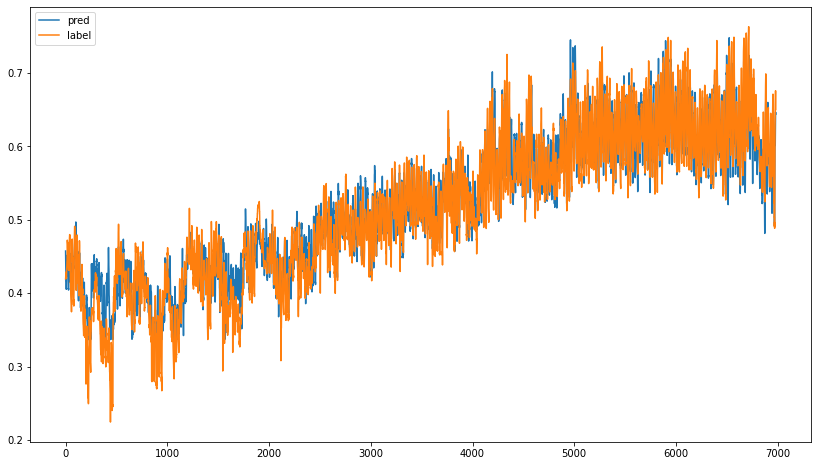

Test MAE: tensor(0.0223)


In [42]:
### Test the newly trained model ###
# load the model architecture and the weights

display_results_after = 200

load = False
if load:
  loaded = torch.load(load_model_path)
  model = loaded["model"]
  model.load_state_dict(loaded["state_dict"])
  model.to(dev)


test_dl = data_loader_wind_us.get_test_loader(data, input_timesteps=input_timesteps,
                                              prediction_timestep=prediction_timesteps, feature_num=num_features,
                                              city_num=num_cities, city_idx=city_idx, feature_idx=feature_idx,
                                              shuffle=False, num_workers=16, test_size=test_size,batch_size=1,
                                              pin_memory=True if dev == torch.device("cuda") else False)


#for x,y in test_dl:
    
#    test_pred = model(x.to(dev))
#    test_loss = F.l1_loss(test_pred, y.to(dev))
#    print(test_loss.cpu().detach().numpy())
#    plot_figure(test_pred.cpu().detach().numpy()[:display_results_after], y.detach().numpy()[:display_results_after])
    


preds = []
labels = []


for idx, (x, y) in enumerate(test_dl):
    test_pred = model(x.to(dev))
    preds.append(test_pred.cpu().detach().reshape(-1))
    labels.append(y.cpu().detach().reshape(-1))
    if idx > (len(test_dl)-1000):
      break

print(preds[0].shape)

plot_figure(preds, labels)
preds = torch.stack(preds)
labels = torch.stack(labels)
test_loss = F.l1_loss(preds, labels)
print("Test MAE: " + str(test_loss))





---


## **TRANSFORM MODEL IN NON TPU MODEL (ALSO SAVING WEIGHTS)** 

## **-- Need to repeat the model --**

In [ ]:
dir = '/content/drive/My Drive/Colab Notebooks/Model/Weights/tpu_model_lag'+ str(lag) + '.h5'
model.save_weights(dir, overwrite=True)


inferencing_model =  kr.Sequential([
              kr.Input(shape=input_shape),
              tt.PositionalEncoding(broadcast=True),
              tt.EncoderLayer(input_length, d_model, head_num, dense_units, initializer, softmax_type),
              tt.EncoderLayer(input_length, d_model, head_num, dense_units, initializer, softmax_type),
              tt.EncoderLayer(input_length, d_model, head_num, dense_units, initializer, softmax_type),
              # tt.EncoderLayer(input_length, d_model, head_num, dense_units, initializer, softmax_type),
              # tt.EncoderLayer(input_length, d_model, head_num, dense_units, initializer, softmax_type),
              # tt.EncoderLayer(input_length, d_model, head_num, dense_units, initializer, softmax_type),
              kr.layers.Flatten(),
              kr.layers.Dense(tf.reduce_prod(output_shape), activation='linear'),
              kr.layers.Reshape(output_shape),
              ])
inferencing_model.load_weights(dir)
inferencing_model.summary()

pred = inferencing_model.predict(x_test)
mae = kr.metrics.mae(y_test.numpy().flatten(), pred.flatten())
print("\n\n######################## Results ##########################################")
print(f'test mae: {np.mean(mae)}')

## **Save entire model.**

In [ ]:
dir = '/content/drive/My Drive/Colab Notebooks/Model/Entire_Model/tpu_model_lag' + str(lag)

localhost_save_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")
model.save(dir, options=localhost_save_option)

# # Restore the weights
model2 = tf.keras.models.load_model(dir, options=localhost_save_option, custom_objects={
    'lr': tt.get_lr_metric, 
    'CustomSchedule':tt.CustomSchedule
})

model2.summary()

pred = model.predict(x_test)
mae = kr.metrics.mae(y_test.numpy().flatten(), pred.flatten())
print("\n\n######################## Results ##########################################")
print(f'test mae: {np.mean(mae)}')

## **Test of the learning rate curve**

In [ ]:
d_model = 256
warmup_steps = 50
factor1=-0.6
factor2=-1.5

temp_learning_rate_schedule = tt.CustomSchedule(d_model, warmup_steps=warmup_steps, factor1=factor1, factor2=factor2)
plt.figure(figsize=(20, 8))
plt.plot(temp_learning_rate_schedule(tf.range(10000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()